# CS5814: Assignment 3

## Problem 4

This problem involves creating a generative adversarial network is to replicate digits from the MNIST dataset.

Two different configurations are tested, both based on a simple FNN architecture for the generator and discriminator.

## Imports and config

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
from torchvision import transforms, datasets
from torchvision.utils import make_grid, save_image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import random
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Configure Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/My Drive/CS5814/HW3/Q4

/content/drive/My Drive/CS5814/HW3/Q4


In [ ]:
dir = "GAN_images_2"

In [ ]:
!mkdir GAN_images_2

mkdir: cannot create directory ‘GAN_images_2’: File exists


## MNIST Dataset download and configuration

In [ ]:
batch_size = 512

transform = transforms.Compose([transforms.ToTensor(), #])
                               transforms.Normalize((0.5,), (0.5,))]) # for normalzing between -1,1])

# Loading data
MNIST_data_train = datasets.MNIST("", train=True, download=True,transform=transform)
MNIST_data_test = datasets.MNIST("", train=False, download=True,transform=transform)


# GAN Model Definition
## Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_width=10,
                 lw=(784, 784, 784),
                 dropout_r=0,
                 activation_r=0.2,
                 output_a="Tanh"):
        super().__init__()

        # Activiation functions
        # Note this is directly related to the transform used on the dataset
        #   as they need to match for the current plotting config
        a = nn.LeakyReLU(activation_r)

        if output_a == "Sigmoid":
          output_act = nn.Sigmoid()  
        elif output_a == "Tanh":
          output_act = nn.Tanh()

        # Dropout
        d = nn.Dropout(dropout_r)

        # Layer definitions
        self.input_dim = input_width
        l1 = nn.Linear(self.input_dim, lw[0])
        l2 = nn.Linear(lw[0], lw[1])
        l3 = nn.Linear(lw[1], lw[2])
        l4 = nn.Linear(lw[2], 784)
        
        layers = [l1, a, d, l2, a, d, l3, a, d, l4, output_act]

        self.module_list = nn.ModuleList(layers)

    def forward(self, x):
        for f in self.module_list:
            x = f(x)

        x = x.view(-1,1,28,28)
        return x

## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_width=784, 
                 lw=(784, 784, 784),
                 dropout_r=0,
                 activation_r=0.2,
                 output_a="Sigmoid"):
        super().__init__()

        # Activiation functions
        # Note this is directly related to the transform used on the dataset
        a = nn.LeakyReLU(activation_r)
        output_act = nn.Sigmoid()  


        # Dropout
        d = nn.Dropout(dropout_r)

        # Layer definitions
        self.input_dim = input_width
        l1 = nn.Linear(self.input_dim, lw[0])
        l2 = nn.Linear(lw[0], lw[1])
        l3 = nn.Linear(lw[1], lw[2])
        l4 = nn.Linear(lw[2], 1)

        layers = [l1, a, d, l2, a, d, l3, a, d, l4, output_act]

        self.module_list = nn.ModuleList(layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        for f in self.module_list:
            x = f(x)
        return x

## Supporting functions

In [ ]:
def generate_noise(sample_size, noise_size):
    return torch.randn(sample_size, noise_size).to(device)

In [ ]:
def patcher(img, epoch):
    """
    Hack to patch tensors into single image, plot and save.
    """

    imgs = torch.reshape(img,(-1,28,28))
    rows = []
    w = 8

    for row_id in range(w):
        row = imgs[w * row_id]
        for col_id in range(1,w):
            row = torch.hstack((row, imgs[row_id*w+col_id]))
        rows.append(row)

    output_img = rows[0]
    for row_id in range(1,w):
        output_img = torch.vstack((output_img, rows[row_id]))

    plt.imshow(output_img,cmap='gray')
    plt.axis('off')
    plt.savefig("{}/epoch_{}.png".format(dir, str(epoch).zfill(3)),
                bbox_inches='tight',
                dpi=600)
    
    plt.clf()

## Training subloops
### Generator

In [ ]:
def train_generator(optimizer, data_fake):
    optimizer.zero_grad()

    # Infer the batch size to generate real labels
    batch_size = data_fake.size(0)
    real_label = torch.ones(batch_size, 1).to(device)

    # Pass generate data to discriminator
    output_D = discriminator(data_fake)
    loss_G = criterion(output_D, real_label)
    loss_G.backward()

    optimizer.step()

    return loss_G

### Discriminator

In [ ]:
def train_discriminator(optimizer, data_real, data_fake):
    optimizer.zero_grad()

    # Infer the batch size to generate real and fake labels
    batch_size = data_real.size(0)
    real_label = torch.ones(batch_size, 1).to(device)
    fake_label = torch.zeros(batch_size, 1).to(device)

    # Real forward and backward pass
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)

    # Fake forward and backward pass
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)

    loss_real.backward()
    loss_fake.backward()

    optimizer.step()

    # Collate loss
    total_loss = loss_real + loss_fake
    return total_loss

## Configuring Traning Instance

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

# Learning parameters
batch_size = 512
epochs = 100
num_steps_D = 1 # number of steps to apply to the discriminator training
noise_dim = 10

# Creating GAN
generator = Generator(input_width=noise_dim).to(device)
discriminator = Discriminator().to(device)
generator.train()
discriminator.train()
print(generator)
print(discriminator)

# Optimizers and loss function
optim_g = optim.Adam(generator.parameters(), lr=0.0005)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0005)
criterion = nn.BCELoss()

# Generating DataLoaders
train_dl = torch.utils.data.DataLoader(MNIST_data_train,
                                       batch_size=batch_size,
                                       shuffle=True)

test_dl = torch.utils.data.DataLoader(MNIST_data_train,
                                       batch_size=batch_size,
                                       shuffle=False)

# Training noise to display progress
# Noise_size needs to be the same size as the input to generator
# 64 as tracking 64 total images (8x8)
noise = generate_noise(sample_size=64, noise_size=noise_dim)

# Tracking arrays
losses_g = []
losses_d = []
images = []
loss_train_G = []
loss_train_D = []


Generator(
  (module_list): ModuleList(
    (0): Linear(in_features=10, out_features=784, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=784, out_features=784, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=784, out_features=784, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0, inplace=False)
    (9): Linear(in_features=784, out_features=784, bias=True)
    (10): Tanh()
  )
)
Discriminator(
  (module_list): ModuleList(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=784, out_features=784, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=784, out_features=784, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0, inplace=False)
    

### Traning Loop

In [ ]:
for epoch in range(epochs):

    # Tracking losses for epoch
    loss_D = 0
    loss_G = 0

    for i, data in enumerate(train_dl):
        data_real = data[0].to(device)  # Don't need the label
        batch_size = data_real.shape[0]

        # Train discriminator
        for j in range(num_steps_D):
          data_fake = generator(generate_noise(batch_size, noise_dim)).detach()
          loss_D += train_discriminator(optim_d, data_real, data_fake).item()

        # Train generator
        data_fake = generator(generate_noise(batch_size, noise_dim))
        loss_G += train_generator(optim_g, data_fake).item()

    # Display generate image from noise for the epoch
    generator.eval()
    generated_img = generator(noise).cpu().detach()
    generator.train()

    # Saving image
    patcher(generated_img, epoch)

    # Calculating average losses based on step counts
    loss_G /= (i+1)
    loss_D /= ((j+1)*(i+1))

    # Tracking losses and printing information
    loss_train_G.append(loss_G)
    loss_train_D.append(loss_D)
    print("Epoch:{}, Loss_G:{}, Loss_D:{}".format(epoch, loss_G, loss_D))

# Saving models (could be done with .state_dict())
torch.save(generator, "{}/generator".format(dir))
torch.save(discriminator, "{}/discriminator".format(dir))


Epoch:0, Loss_G:10.274409749245239, Loss_D:0.3304217443055677
Epoch:1, Loss_G:12.524682683459783, Loss_D:0.0030618380255950563
Epoch:2, Loss_G:11.8307460283829, Loss_D:1.9949218089311477e-05
Epoch:3, Loss_G:12.803952402987722, Loss_D:1.1965351917351037e-05
Epoch:4, Loss_G:13.265057701175495, Loss_D:8.390120729788994e-06
Epoch:5, Loss_G:13.594955298860194, Loss_D:6.336254635521149e-06
Epoch:6, Loss_G:13.691957829362256, Loss_D:5.1909533925998216e-06
Epoch:7, Loss_G:13.881977881415416, Loss_D:4.330256309127065e-06
Epoch:8, Loss_G:14.163370382987846, Loss_D:3.5689046171683003e-06
Epoch:9, Loss_G:14.304989952152058, Loss_D:3.036190937024712e-06
Epoch:10, Loss_G:13.756580805374405, Loss_D:3.363660182959254e-06
Epoch:11, Loss_G:17.61496967784429, Loss_D:0.002694770029730319
Epoch:12, Loss_G:70.56839167061499, Loss_D:5.591346854596775e-06
Epoch:13, Loss_G:72.14916222782459, Loss_D:4.780205479890063e-07
Epoch:14, Loss_G:71.87428277225818, Loss_D:2.5569014089626125e-07
Epoch:15, Loss_G:71.65443

<Figure size 432x288 with 0 Axes>

## Post training 

### Plotting

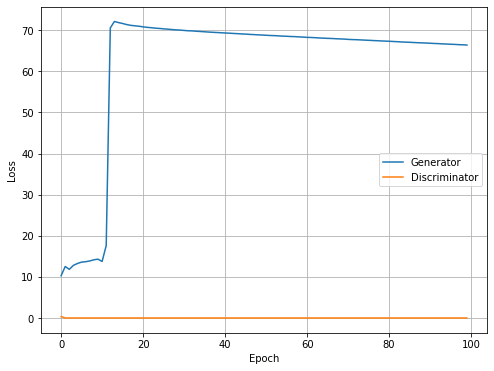

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(loss_train_G, label='Generator')
plt.plot(loss_train_D, label='Discriminator')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()
plt.show()

## Evaluating performance

In [ ]:
# Setting random seeds
RANDOM_SEED = 3819969

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [ ]:
generator.eval()
discriminator.eval()

for i, real_img_data in enumerate(test_dl):

        real_img_X = real_img_data[0].to(device)  # Don't need the label

        real_preds = discriminator(real_img_X).cpu().detach().numpy()
        batch_size = real_img_X.size(0)
        real_label = torch.ones(batch_size, 1).numpy()
        # Pass generate data to discriminator
        output_D = discriminator(data_fake)

        if i == 0:
          break
test_noise = generate_noise(512, noise_dim)
fake_imag_X = generator(test_noise)
fake_label = torch.zeros(batch_size, 1).numpy()
fake_preds = discriminator(fake_imag_X).cpu().detach().numpy()

real_preds = (real_preds >= 0.5).astype(int)
fake_preds = (fake_preds >= 0.5).astype(int)

net_preds = np.concatenate((real_preds, fake_preds))
net_label = np.concatenate((real_label, fake_label))

tn, fp, fn, tp = confusion_matrix(net_label, net_preds).ravel()

test_acc = accuracy_score(net_label, net_preds)


print("\n\nConfusion Matrix:")
print("TP: {}, FP:{}\nFN:{}, TN:{}".format(tp, fp, fn, tn))
print("\nAccuracy {:.4f}".format(test_acc))
print("Precision: {:.4f}".format(tp/(tp+fp)))
print("Recall: {:.4f}".format(tp/(tp+fn)))
print("F1: {:.4f}".format(tp/(tp+0.5*(fp+fn))))



Confusion Matrix:
TP: 512, FP:0
FN:0, TN:512

Accuracy 1.0000
Precision: 1.0000
Recall: 1.0000
F1: 1.0000


## Improving Generator and Discriminator

In [ ]:
dir = "GAN_images_5"

In [ ]:
!mkdir GAN_images_5

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

# Learning parameters
batch_size = 512
epochs = 300
num_steps_D = 3 # number of steps to apply to the discriminator training
num_steps_G = 1
noise_dim = 64
lr = 0.0002
# Creating GAN

generator = Generator(input_width=noise_dim)
                      
discriminator = Discriminator()


generator = Generator(input_width=noise_dim,
                      lw=(256,512,1024),
                      output_a="Tanh")     
          
discriminator = Discriminator(lw=(1024,512,256),
                      dropout_r=0.3)


generator = generator.to(device)
discriminator = discriminator.to(device)
generator.train()
discriminator.train()
print(generator)
print(discriminator)

# Optimizers and loss function
optim_g = optim.Adam(generator.parameters(), lr=lr)
optim_d = optim.Adam(discriminator.parameters(), lr=lr)
criterion = nn.BCELoss()

# Generating DataLoaders
train_dl = torch.utils.data.DataLoader(MNIST_data_train,
                                       batch_size=batch_size,
                                       shuffle=True)

test_dl = torch.utils.data.DataLoader(MNIST_data_train,
                                       batch_size=batch_size,
                                       shuffle=False)

# Training noise to display progress
# Noise_size needs to be the same size as the input to generator
# 64 as tracking 64 total images (8x8)
noise = generate_noise(sample_size=64, noise_size=noise_dim)

# Tracking arrays
losses_g = []
losses_d = []
images = []
loss_train_G = []
loss_train_D = []


Generator(
  (module_list): ModuleList(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0, inplace=False)
    (9): Linear(in_features=1024, out_features=784, bias=True)
    (10): Tanh()
  )
)
Discriminator(
  (module_list): ModuleList(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=F

In [ ]:
for epoch in range(epochs):

    # Tracking losses for epoch
    loss_D = 0
    loss_G = 0

    for i, data in enumerate(train_dl):
        data_real = data[0].to(device)  # Don't need the label
        batch_size = data_real.shape[0]

        # Train discriminator
        for j in range(num_steps_D):
          data_fake = generator(generate_noise(batch_size, noise_dim)).detach()
          loss_D += train_discriminator(optim_d, data_real, data_fake).item()

        # Train generator
        for k in range(num_steps_G):
          data_fake = generator(generate_noise(batch_size, noise_dim))
          loss_G += train_generator(optim_g, data_fake).item()

    # Display generate image from noise for the epoch
    generator.eval()
    generated_img = generator(noise).cpu().detach()
    generator.train()

    # Saving image
    patcher(generated_img, epoch)

    # Calculating average losses based on step counts
    loss_G /= ((k+1)*(i+1))
    loss_D /= ((j+1)*(i+1))

    # Tracking losses and printing information
    loss_train_G.append(loss_G)
    loss_train_D.append(loss_D)
    print("Epoch:{}, Loss_G:{}, Loss_D:{}".format(epoch, loss_G, loss_D))

# Saving models (could be done with .state_dict())
torch.save(generator, "{}/generator".format(dir))
torch.save(discriminator, "{}/discriminator".format(dir))


Epoch:0, Loss_G:9.855775637646852, Loss_D:0.0787436358167709
Epoch:1, Loss_G:10.407781346369598, Loss_D:0.07674391456750763
Epoch:2, Loss_G:9.174761537778176, Loss_D:0.07276678137623607
Epoch:3, Loss_G:8.388294607906019, Loss_D:0.02667644884342612
Epoch:4, Loss_G:8.566521866846893, Loss_D:0.008369189064218373
Epoch:5, Loss_G:8.968085911314366, Loss_D:0.008869267604757747
Epoch:6, Loss_G:9.740715289520004, Loss_D:0.011031935586545374
Epoch:7, Loss_G:9.378944552550882, Loss_D:0.059191040420775845
Epoch:8, Loss_G:9.717960220272259, Loss_D:0.013155373730196875
Epoch:9, Loss_G:9.764701350260589, Loss_D:0.012193009289708989
Epoch:10, Loss_G:9.665790662927142, Loss_D:0.017553643333429004
Epoch:11, Loss_G:11.025308928247226, Loss_D:0.017813069421152117
Epoch:12, Loss_G:10.355257919279195, Loss_D:0.012506297715192419
Epoch:13, Loss_G:10.185046712220725, Loss_D:0.0762992998709084
Epoch:14, Loss_G:9.615763235900362, Loss_D:0.03026363729383523
Epoch:15, Loss_G:9.686094449738325, Loss_D:0.025780050

<Figure size 432x288 with 0 Axes>

## Post training 
### Plotting

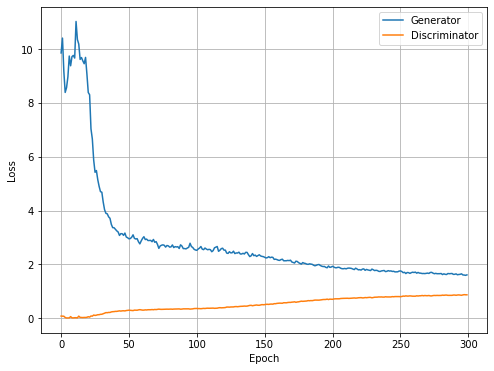

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(loss_train_G, label='Generator')
plt.plot(loss_train_D, label='Discriminator')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()
plt.show()

## Evaluating performance

In [ ]:
# Setting random seeds
RANDOM_SEED = 3819969

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [ ]:
generator.eval()
discriminator.eval()

for i, real_img_data in enumerate(test_dl):

        real_img_X = real_img_data[0].to(device)  # Don't need the label

        real_preds = discriminator(real_img_X).cpu().detach().numpy()
        batch_size = real_img_X.size(0)
        real_label = torch.ones(batch_size, 1).numpy()
        # Pass generate data to discriminator
        output_D = discriminator(data_fake)

        if i == 0:
          break
test_noise = generate_noise(512, noise_dim)
fake_imag_X = generator(test_noise)
fake_label = torch.zeros(batch_size, 1).numpy()
fake_preds = discriminator(fake_imag_X).cpu().detach().numpy()

real_preds = (real_preds >= 0.5).astype(int)
fake_preds = (fake_preds >= 0.5).astype(int)

net_preds = np.concatenate((real_preds, fake_preds))
net_label = np.concatenate((real_label, fake_label))

tn, fp, fn, tp = confusion_matrix(net_label, net_preds).ravel()

test_acc = accuracy_score(net_label, net_preds)

print("\n\nConfusion Matrix:")
print("TP: {}, FP:{}\nFN:{}, TN:{}".format(tp, fp, fn, tn))
print("\nAccuracy {:.4f}".format(test_acc))
print("Precision: {:.4f}".format(tp/(tp+fp)))
print("Recall: {:.4f}".format(tp/(tp+fn)))
print("F1: {:.4f}".format(tp/(tp+0.5*(fp+fn))))



Confusion Matrix:
TP: 387, FP:22
FN:125, TN:490

Accuracy 0.8564
Precision: 0.9462
Recall: 0.7559
F1: 0.8404


## Continuing training for output video!

In [ ]:
generator.train()
discriminator.train()

for epoch in range(300, epochs+300, 1):

    # Tracking losses for epoch
    loss_D = 0
    loss_G = 0

    for i, data in enumerate(train_dl):
        data_real = data[0].to(device)  # Don't need the label
        batch_size = data_real.shape[0]

        # Train discriminator
        for j in range(num_steps_D):
          data_fake = generator(generate_noise(batch_size, noise_dim)).detach()
          loss_D += train_discriminator(optim_d, data_real, data_fake).item()

        # Train generator
        for k in range(num_steps_G):
          data_fake = generator(generate_noise(batch_size, noise_dim))
          loss_G += train_generator(optim_g, data_fake).item()

    # Display generate image from noise for the epoch
    generator.eval()
    generated_img = generator(noise).cpu().detach()
    generator.train()

    # Saving image
    patcher(generated_img, epoch)

    # Calculating average losses based on step counts
    loss_G /= ((k+1)*(i+1))
    loss_D /= ((j+1)*(i+1))

    # Tracking losses and printing information
    loss_train_G.append(loss_G)
    loss_train_D.append(loss_D)
    print("Epoch:{}, Loss_G:{}, Loss_D:{}".format(epoch, loss_G, loss_D))

# Saving models (could be done with .state_dict())
torch.save(generator, "{}/generator".format(dir))
torch.save(discriminator, "{}/discriminator".format(dir))

Epoch:300, Loss_G:2.0655495271844377, Loss_D:0.7775601997213849
Epoch:301, Loss_G:1.7368216464074993, Loss_D:0.7837030397633374
Epoch:302, Loss_G:1.6671738159858573, Loss_D:0.799024040752885
Epoch:303, Loss_G:1.6301633159993059, Loss_D:0.8143685108187508
Epoch:304, Loss_G:1.6143706067133758, Loss_D:0.8219772893830207
Epoch:305, Loss_G:1.6079078579353074, Loss_D:0.8309341749902499
Epoch:306, Loss_G:1.5896491034556244, Loss_D:0.8373633517047107
Epoch:307, Loss_G:1.5597594440993616, Loss_D:0.8498322342411947
Epoch:308, Loss_G:1.5550474069886289, Loss_D:0.857558244870881
Epoch:309, Loss_G:1.5562921408879555, Loss_D:0.8617079020556757
Epoch:310, Loss_G:1.5352366778810145, Loss_D:0.8688121416137717
Epoch:311, Loss_G:1.5355709952823187, Loss_D:0.8709294506385501
Epoch:312, Loss_G:1.55113687959768, Loss_D:0.8712601826689338
Epoch:313, Loss_G:1.5360716823804177, Loss_D:0.8775051234468902
Epoch:314, Loss_G:1.5404525954844588, Loss_D:0.87516717402275
Epoch:315, Loss_G:1.5322918861599293, Loss_D:0

<Figure size 432x288 with 0 Axes>